
# Task 2: Quantitative Analysis with TA-Lib and PyNance 
## Objectives:
- Load & prepare OHLCV data
- Compute technical indicators (SMA, EMA, RSI, MACD, ATR, Bollinger Bands) using TA-Lib
- Compute Sharpe ratio, Value at Risk placeholder
- Visualize price, indicators, and performance

## KPIs:
- Accuracy of indicators
- Completeness of Data Analysis

# Imports, Constants, and Path Definitions 

In [29]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as psub
import plotly.io as pio

print("Default renderer:", pio.renderers.default)
pio.renderers.default = "colab"

## Setup Pathz
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
scripts_path = project_root / 'scripts'
scripts_path_str = str(scripts_path)
if scripts_path_str not in sys.path:
    sys.path.insert(0, scripts_path_str)

# Local modules
from data_loader import DataLoader
from quant_analysis import QuantAnalysis, MovingAverageConfig, MACDConfig, RSIConfig, ATRConfig, BollingerBandsConfig


plt.style.use("seaborn-v0_8")
sns.set_context("talk")
TICKERS = ["AAPL", "AMZN", "MSFT", "NVDA","GOOG", "META"]
DATA_DIR = Path("../data")
PRICE_PATH = DATA_DIR / f"{TICKERS[0]}.csv"

Default renderer: browser


## 1. Load & Prepare Data

In [11]:
loader = DataLoader()
price_df = loader.load_stock_price(PRICE_PATH, preview=False)
price_df.head()
### Basic inspection
print("Columns:", price_df.columns.tolist())
print(price_df.select_dtypes(include="number").describe())

Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
             Close         High          Low         Open        Volume
count  3774.000000  3774.000000  3774.000000  3774.000000  3.774000e+03
mean     53.841169    54.383801    53.247465    53.801628  2.640640e+08
std      55.064042    55.627235    54.440128    55.009182  2.345629e+08
min       2.345299     2.459265     2.345299     2.380989  2.404830e+07
25%      15.050355    15.183043    14.901886    15.007580  9.581845e+07
50%      26.975808    27.168844    26.836844    27.010205  1.667348e+08
75%      74.664204    75.252383    73.553555    74.127927  3.777410e+08
max     196.256592   197.752460   195.156944   196.167437  1.880998e+09


## 2. Add Technical Indicators

In [12]:
# Selectively enabling indicators by passing configs.
qa = QuantAnalysis(periods_per_year=252)
price_ind_df = qa.add_indicators(
    price_df,
    prefix="TA_",
    ma_cfg=MovingAverageConfig(sma_period=20, ema_period=20),
    rsi_cfg=RSIConfig(period=14),
    macd_cfg=MACDConfig(fast=12, slow=26, signal=9),
    atr_cfg=ATRConfig(period=14),
    bbands_cfg=BollingerBandsConfig(period=20, nbdevup=2.0, nbdevdn=2.0, matype=0),
)
price_ind_df.tail()

,Date,Close,High,Low,Open,Volume,TA_SMA_20,TA_EMA_20,TA_RSI_14,TA_MACD,TA_MACD_signal,TA_MACD_hist,TA_ATR_14,TA_BB_upper,TA_BB_mid,TA_BB_lower
3769,2023-12-22,191.788757,193.581821,191.164647,193.353962,37149600,191.856618,191.510231,54.672784,2.633141,3.235256,-0.602115,2.766028,197.478146,191.856618,186.235090
3770,2023-12-26,191.243912,192.076049,191.025969,191.798670,28919300,192.018094,191.484867,53.090049,2.304751,3.049155,-0.744404,2.643460,197.367843,192.018094,186.668345
3771,2023-12-27,191.342972,191.689703,189.302247,190.689158,48087700,192.154308,191.471353,53.354446,2.029104,2.845145,-0.816041,2.625174,197.285152,192.154308,187.023465
3772,2023-12-28,191.768951,192.838849,191.362784,192.323710,34049900,192.362839,191.499696,54.540999,1.823998,2.640915,-0.816918,2.544510,197.056446,192.362839,187.669231
3773,2023-12-29,190.728775,192.581275,189.936256,192.085953,42672100,192.490633,191.426275,51.121347,1.559539,2.424640,-0.865101,2.551689,196.848102,192.490633,188.133164


In [ ]:
## 3. Compute Returns & Performance Metrics

In [25]:
price_ret_df = qa.compute_returns(price_ind_df, method="simple")

sharpe = qa.sharpe_ratio(price_ret_df)
sortino = qa.sortino_ratio(price_ret_df)
mdd = qa.max_drawdown(price_ret_df)
calmar = qa.calmar_ratio(price_ret_df)

metrics = {
    "Sharpe (annualized)": sharpe,
    "Sortino (annualized)": sortino,
    "Max Drawdown": mdd,
    "Calmar": calmar,
}
metrics

{'Sharpe (annualized)': 1.1364002341249546,
 'Sortino (annualized)': 1.609185902848581,
 'Max Drawdown': -0.4379714735422829,
 'Calmar': 157.72129073942185}

## 4. Visualizations

## SMA & EMA

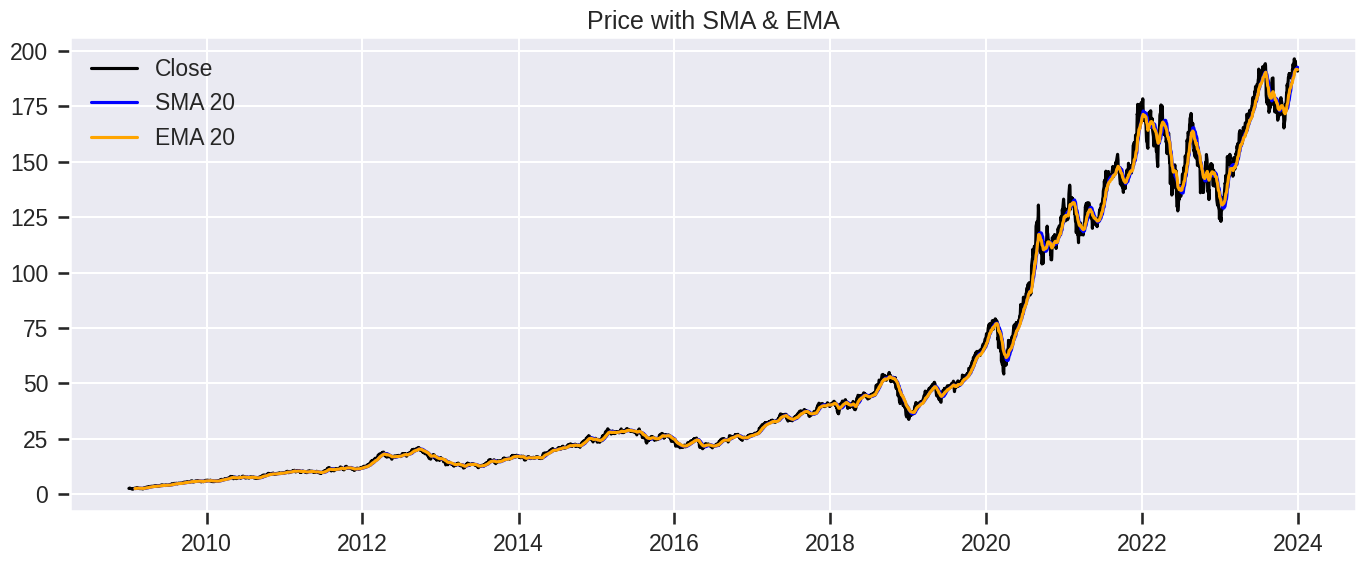

In [16]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(price_ret_df["Date"], price_ret_df["Close"], label="Close", color="black")
ax.plot(price_ret_df["Date"], price_ret_df["TA_SMA_20"], label="SMA 20", color="blue")
ax.plot(price_ret_df["Date"], price_ret_df["TA_EMA_20"], label="EMA 20", color="orange")
ax.set_title("Price with SMA & EMA")
ax.legend()
plt.tight_layout()
plt.show()

## RSI

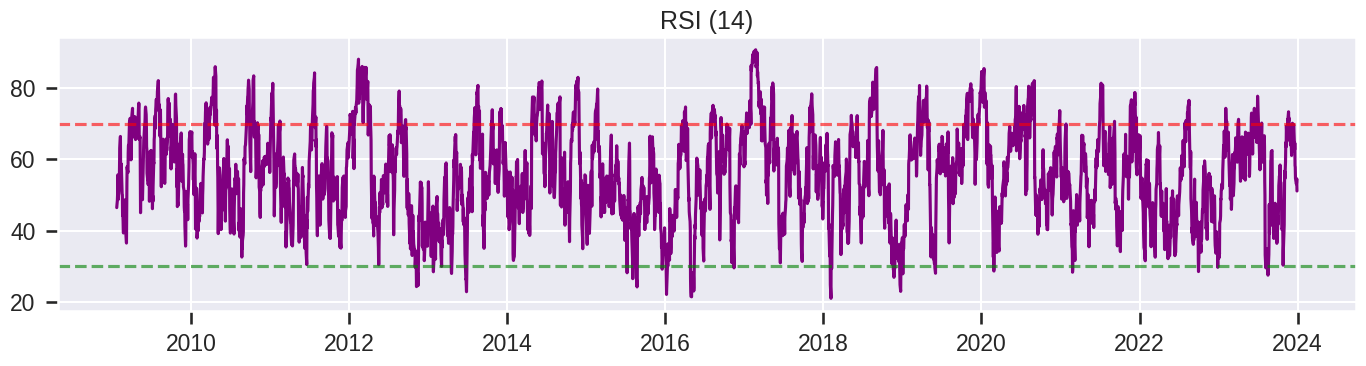

In [18]:
plt.figure(figsize=(14,4))
plt.plot(price_ret_df["Date"], price_ret_df["TA_RSI_14"], color="purple")
plt.axhline(70, color="red", linestyle="--", alpha=0.6)
plt.axhline(30, color="green", linestyle="--", alpha=0.6)
plt.title("RSI (14)")
plt.tight_layout()
plt.show()

## MACD Interactive

In [35]:
fig = psub.make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.6, 0.4])
fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["Close"], name="Close", line=dict(color="black")), row=1, col=1)
fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["TA_MACD"], name="MACD", line=dict(color="purple")), row=2, col=1)
fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["TA_MACD_signal"], name="Signal", line=dict(color="orange")), row=2, col=1)
fig.update_layout(height=600, title="Price & MACD")
fig.show()

## Bollinger Bands

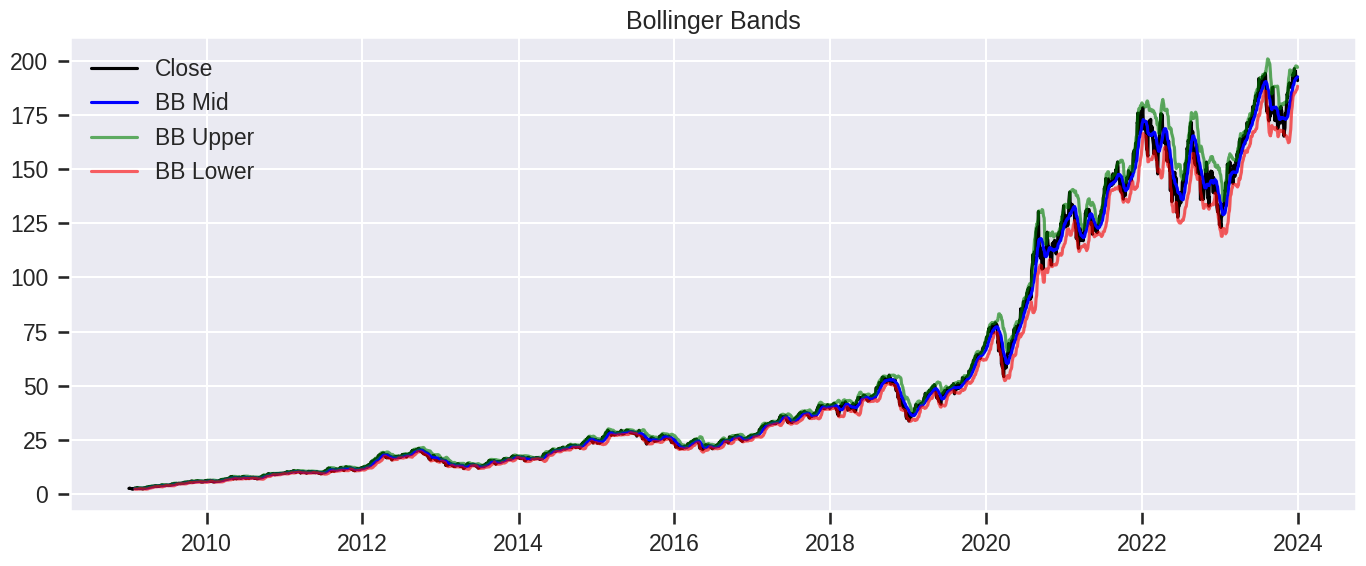

In [21]:
plt.figure(figsize=(14,6))
plt.plot(price_ret_df["Date"], price_ret_df["Close"], label="Close", color="black")
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_mid"], label="BB Mid", color="blue")
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_upper"], label="BB Upper", color="green", alpha=0.6)
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_lower"], label="BB Lower", color="red", alpha=0.6)
plt.fill_between(price_ret_df["Date"], price_ret_df["TA_BB_lower"], price_ret_df["TA_BB_upper"], color="gray", alpha=0.1)
plt.title("Bollinger Bands")
plt.legend()
plt.tight_layout()
plt.show()

## Cumulative Return & Drawdown

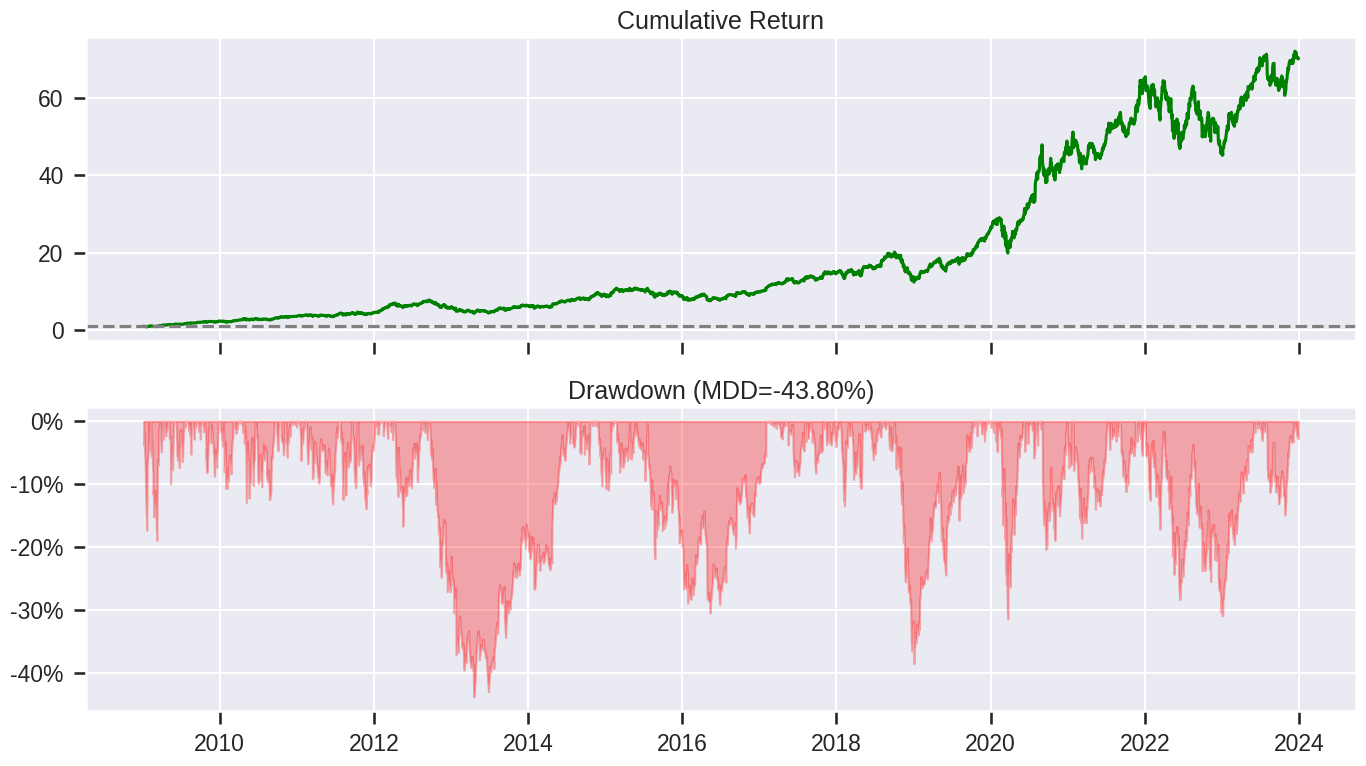

In [22]:
equity = price_ret_df["cumulative_return"]
running_max = equity.cummax()
drawdown = (equity - running_max) / running_max

fig, axes = plt.subplots(2, 1, figsize=(14,8), sharex=True)
axes[0].plot(price_ret_df["Date"], equity, color="green")
axes[0].set_title("Cumulative Return")
axes[0].axhline(1.0, color="gray", linestyle="--")

axes[1].fill_between(price_ret_df["Date"], drawdown, 0, color="red", alpha=0.3)
axes[1].set_title(f"Drawdown (MDD={mdd:.2%})")
axes[1].yaxis.set_major_formatter(lambda v, pos: f"{v:.0%}")
plt.tight_layout()
plt.show()

## 5. Export

In [34]:
price_ret_df["ticker"] = f"{TICKERS[0]}"
price_ret_df.to_csv(f"../data/{CURRENT_TICKER}_task2_price_indicators.csv", index=False)